In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
import datasets
import numpy as np

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)

100%|██████████| 3/3 [00:00<00:00, 823.27it/s]


In [105]:
device = "cpu"
block_size = 64
test_size = 1500

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long).to(device)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [106]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=44, num_layers=5):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens, top_k=10):
        for _ in range(max_new_tokens):
            out = self(input_ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            input_ids = torch.cat((input_ids, step_res), dim=1)

        return input_ids

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )

    def forward(self, x):
        B, T, C = x.shape
        x = x + F.sigmoid(self.q(x)) * F.pad(x[:, :T-1, :], (0, 0, 1, 0))
        x = x + self.mlp(x)
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=block_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=block_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            x = torch.tensor([dataset.stoi[s] for s in "And now "], dtype=torch.long)[None,...].to(device)
            y = self.model.generate(x, 64)[0]
            print("".join([dataset.itos[int(i)] for i in y]))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999, last_epoch=-1)
        return [optim], [sched]

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else "cpu")
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 94.2 K
-------------------------------
94.2 K    Trainable params
0         Non-trainable params
94.2 K    Total params
0.377     Total estimated model params size (MB)


Epoch 3: 100%|██████████| 118/118 [00:04<00:00, 28.32it/s, loss=1.76, v_num=73, test_loss=1.950]And now wint out:
Whon
Clift on: and away it all hath in a doby tath the
Epoch 7: 100%|██████████| 118/118 [00:04<00:00, 28.32it/s, loss=1.63, v_num=73, test_loss=1.860]And now lengt me nums to lamans:
May; you shalt:
One a me mest
For speak
Epoch 8: 100%|██████████| 118/118 [00:04<00:00, 27.76it/s, loss=1.63, v_num=73, test_loss=1.850]And now any with with himses. After propet.

Show, thou a laman feare,
B
Epoch 9: 100%|██████████| 118/118 [00:04<00:00, 27.87it/s, loss=1.6, v_num=73, test_loss=1.780] And now banity to him
That I thou she done, for the sista for of the dow
Epoch 10: 100%|██████████| 118/118 [00:04<00:00, 27.97it/s, loss=1.61, v_num=73, test_loss=1.760]And now my surl'd-benfingerous say;
This should day your brew the with s
Epoch 11: 100%|██████████| 118/118 [00:04<00:00, 27.84it/s, loss=1.59, v_num=73, test_loss=1.810]And now birth against thing blood.

FRIAR LAURENCE:
He ar

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 118/118 [00:04<00:00, 27.41it/s, loss=1.52, v_num=73, test_loss=1.670]


Epoch 13:  83%|████████▎ | 98/118 [06:14<01:16,  3.82s/it, loss=1.58, v_num=71, test_loss=1.670]


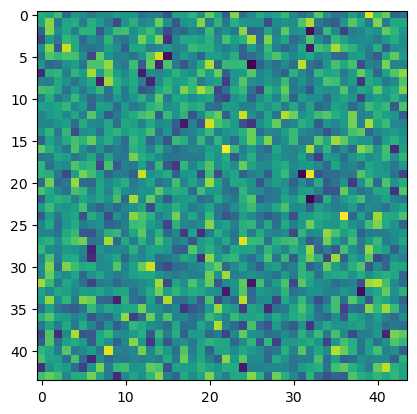

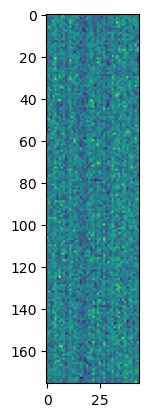

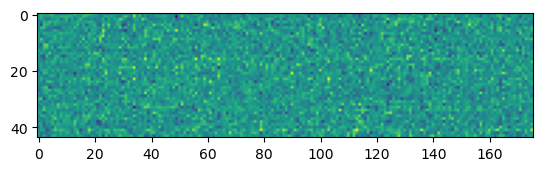

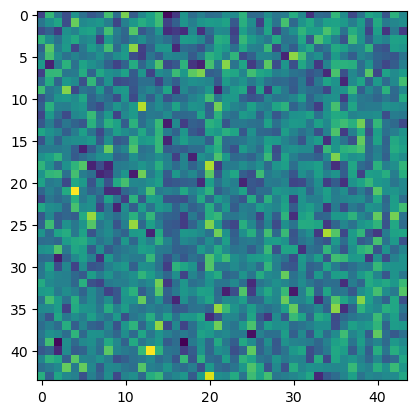

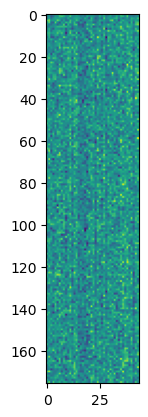

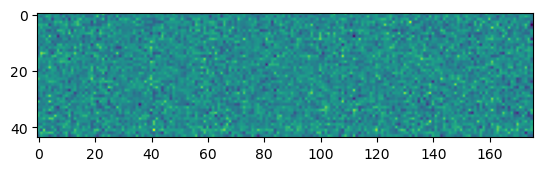

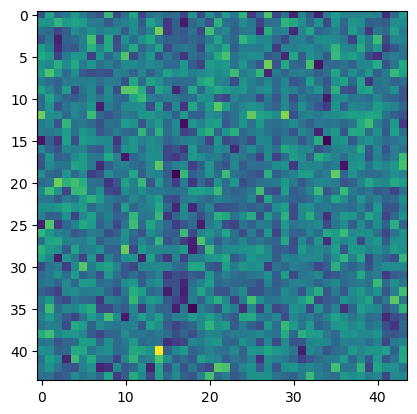

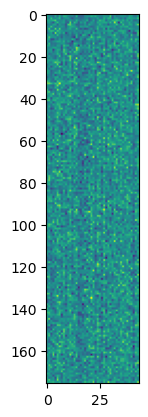

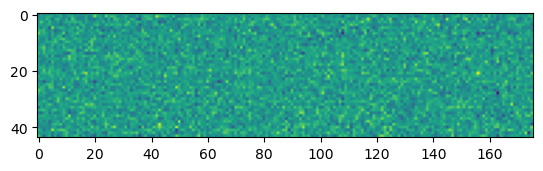

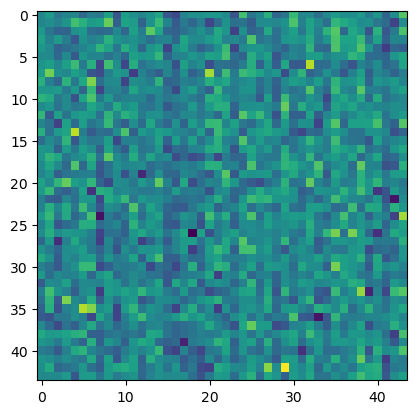

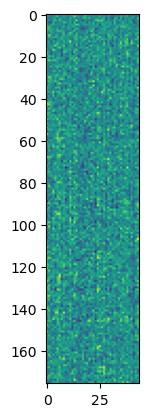

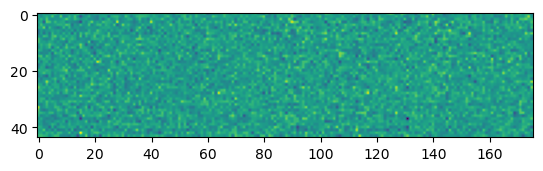

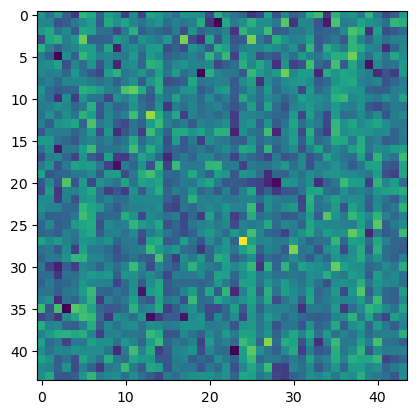

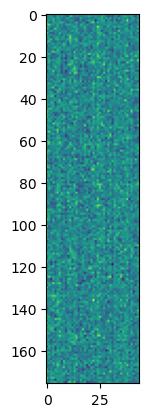

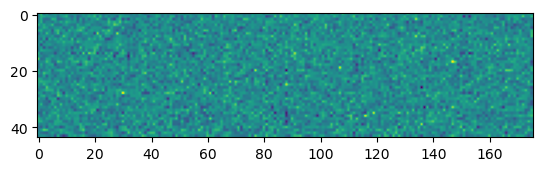

In [107]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.q.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [108]:
y = model.to(device).model.generate(torch.tensor([dataset.stoi[s] for s in "O God, O God!".rjust(block_size)]).unsqueeze(0).to(device), 650)
print("".join([dataset.itos[int(i)] for i in y[0]]))

                                                   O God, O God! think, and to deserve,
I that you
To break outrace, my for trumpeech he want thank him
thou speak made an a first that yielding
Athers thee trimage, take. In me, are witter:
How, son in have but their we land, well one by thee heaven: an at to
safell:
The
me to yons
At the glasdy seems-seem for then and full head sevenged?

DUCHESS OF YORK:
What mark'd in
the credantly spice, in some by, hell, for the with me in three. Where's and have me thee, horts; and prince fly between, and thre to the from to sleech.

LUCIO:
O that these that he is beated, so not deaving mes me fnight; by the poor to more, if noble: and happirest thy caen we all been f
